<a href="https://colab.research.google.com/github/zszazi/awesome-collection-of-google-colab-notebooks/blob/master/Dogs_vs_Cats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
 
% matplotlib inline

In [0]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
featuretools 0.4.1 has requirement pandas>=0.23.0, but you'll have pandas 0.22.0 which is incompatible.
datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.
Done.


In [0]:
from fastai import *
from fastai.vision import *
from fastai.metrics import error_rate
import pprint

In [0]:
path = untar_data(URLs.PETS)

In [0]:
path.ls()

[PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images')]

In [0]:
path_ano = path/'annotations'

In [0]:
path_img = path/'images'

In [0]:
fnames = get_image_files(path_img)

In [0]:
fnames[:5]

[PosixPath('/root/.fastai/data/oxford-iiit-pet/images/american_bulldog_5.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/wheaten_terrier_76.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/scottish_terrier_95.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/german_shorthaired_103.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/english_setter_152.jpg')]

In [0]:
np.random.seed(44)
pat = r'/([^/]+)_\d+.jpg'

In [0]:
print(pat)

/([^/]+)_\d+.jpg


In [0]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224 , bs = 64
                                  ).normalize(imagenet_stats)

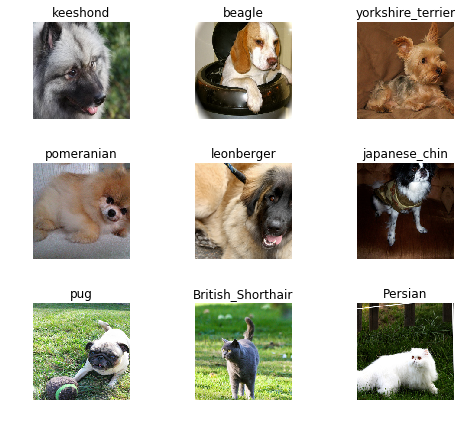

In [0]:
data.show_batch(rows=3,figsize = (7,6))

In [0]:
print(data.classes)

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


# Training using Resnet34 model

In [0]:
learn = cnn_learner(data , models.resnet34 , pretrained=True , metrics = error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
87306240it [00:01, 85112687.46it/s]


In [0]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate,time
0,1.529266,0.344636,0.084574,01:51
1,0.581656,0.252668,0.085250,01:47
2,0.360937,0.198223,0.066306,01:45
3,0.268210,0.170693,0.052774,01:52
4,0.220456,0.171908,0.052097,01:56


In [0]:
learn.save('stage-1')

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

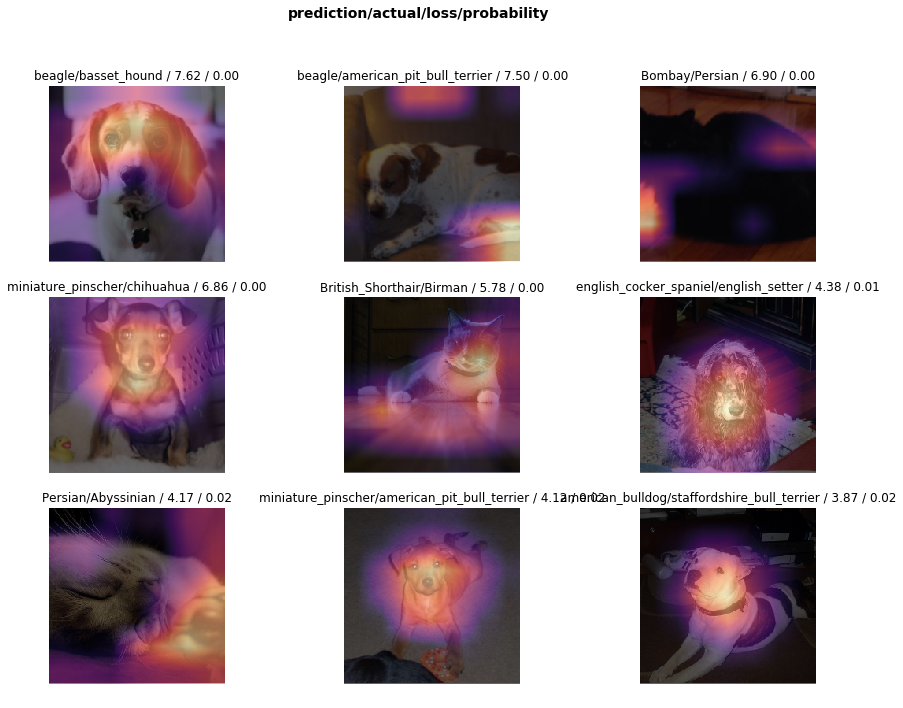

In [0]:
interp.plot_top_losses(9,figsize = (15,11))

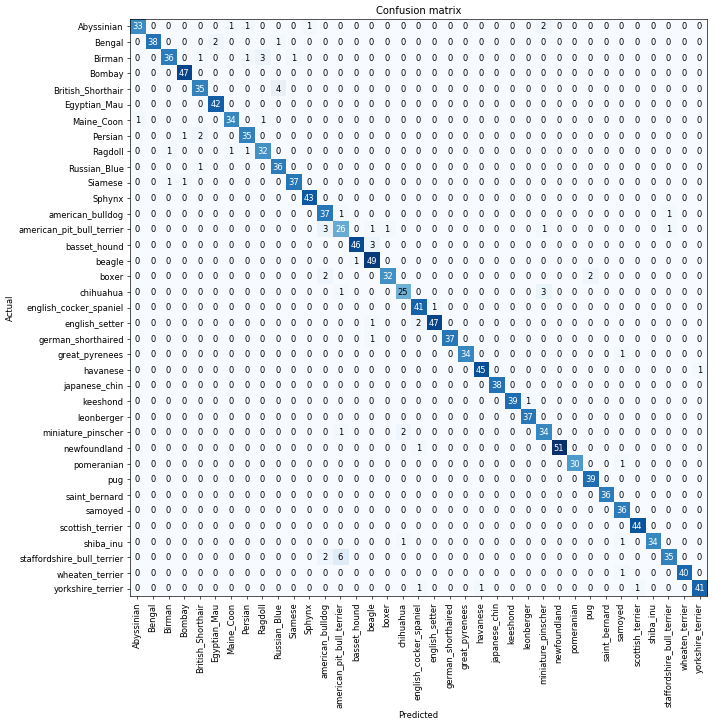

In [0]:
interp.plot_confusion_matrix(figsize = (12,12) , dpi = 60)

In [0]:
interp.most_confused(min_val = 3)

[('staffordshire_bull_terrier', 'american_pit_bull_terrier', 6),
 ('British_Shorthair', 'Russian_Blue', 4),
 ('Birman', 'Ragdoll', 3),
 ('american_pit_bull_terrier', 'american_bulldog', 3),
 ('basset_hound', 'beagle', 3),
 ('chihuahua', 'miniature_pinscher', 3)]

#FINE TUNING

In [0]:
learn.load("stage-1")

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


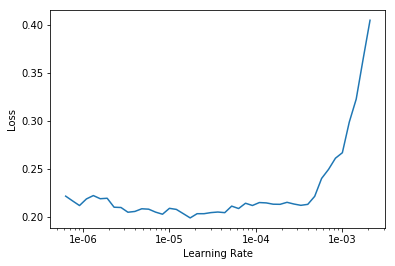

In [0]:
learn.recorder.plot()

In [0]:
learn.unfreeze()
learn.fit_one_cycle(2,max_lr = slice(1e-6 , 1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.209883,0.171555,0.052774,02:01
1,0.184788,0.168727,0.052097,02:03


In [0]:
learn.save('stage-2')

# Predict the breed

In [0]:
def predict(url):
    img = fetch_image(url)
    pred_class,pred_idx,outputs = learn.predict(img)
    res =  zip (learn.data.classes, outputs.tolist())
    predictions = sorted(res, key=lambda x:x[1], reverse=True)
    top_predictions = predictions[0:5]
    pprint.pprint( top_predictions)
    return img.resize(500)

In [0]:
def fetch_image(url):
    response = requests.get(url)
    img = open_image(BytesIO(response.content))
    return img

In [0]:
img_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/6/6b/Taka_Shiba.jpg/330px-Taka_Shiba.jpg"

[('shiba_inu', 0.9403162002563477),
 ('pomeranian', 0.03412158042192459),
 ('samoyed', 0.008922453969717026),
 ('chihuahua', 0.0039041105192154646),
 ('keeshond', 0.0016304784221574664)]


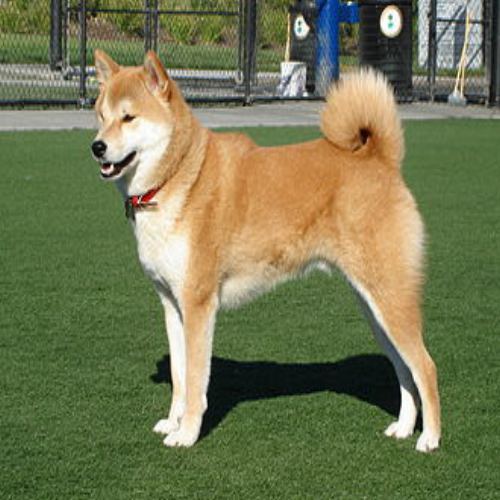

In [0]:
predict(img_url)

# Production of Model

 download the stage-2.pth model which can be found under



```
# content/data/oxford-iiit-pet/images/models/stage-2.pth
```

to your local machine and you can use this to build webapp 